In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.linear_model import LinearRegression

In [40]:
%%sh
ls data

Best_Cities_for_Startups.csv
Best_Countries_for_Startups.csv
City_Populations.csv
Country_Metadata.csv
best_cities_enriched.csv
countries_rankings_enriched.csv
joined_df.csv


In [41]:
df = pd.read_csv("data/countries_rankings_enriched.csv")

# I always forget to delcare an index when I save the csv!!! Oops. 
del df['Unnamed: 0']

# I don't believe 
a reliable model can be built with the dataset provided. BUT we can create a model to predict the variance within a countries ranking to be within mext year.

In [42]:
df

ranking_2021 change_from_2020                 country  total_score  quantity_score  quality_score  business_score change_sign  change_vector  ranking_2020
0            1.0                0           United States      124.420           19.45         101.17            3.80         NaN            0.0           1.0
1            2.0                0          United Kingdom       28.719            8.16          16.86            3.70         NaN            0.0           2.0
2            3.0                0                  Israel       27.741            5.48          19.14            3.13         NaN            0.0           3.0
3            4.0                0                  Canada       19.876            6.58           9.75            3.55         NaN            0.0           4.0
4            5.0                0                 Germany       17.053            3.64           9.93            3.49         NaN            0.0           5.0
5            6.0                4                  Sweden       15.423            2.40           9.24            3.78           +            4.0          10.0
6            7.0                7                   China       15.128            1.33          11.46            2.34           +            7.0          14.0
7            8.0                0             Switzerland       14.943            3.82           7.58            3.54         NaN            0.0           8.0
8            9.0                2               Australia       13.835            4.46           5.88            3.50           -           -2.0           7.0
9           10.0                6               Singapore       13.745            3.21           7.69            2.84           +            6.0          16.0
10          11.0                5         The Netherlands       13.700            3.44           6.96            3.30           -           -5.0           6.0
11          12.0                0                  France       13.286            3.03           6.85            3.41         NaN            0.0          12.0
12          13.0                2                 Estonia       12.428            3.19           5.77            3.47           -           -2.0          11.0
13          14.0                1                 Finland       11.582            2.68           5.26            3.64           -           -1.0          13.0
14          15.0                6                   Spain       11.146            3.48           4.35            3.31           -           -6.0           9.0
15          16.0                1               Lithuania        9.992            3.77           2.98            3.25           -           -1.0          15.0
16          17.0                0                  Russia        9.813            2.17           5.14            2.51         NaN            0.0          17.0
17          18.0                0                 Ireland        9.633            2.51           3.68            3.44         NaN            0.0          18.0
18          19.0                0             South Korea        8.888            0.68           4.96            3.24         NaN            0.0          19.0
19          20.0                3                   India        8.833            1.83           4.40            2.61           +            3.0          23.0
20          21.0                0                   Japan        8.709            0.99           4.42            3.30         NaN            0.0          21.0
21          22.0                0                 Denmark        8.368            2.04           2.68            3.65         NaN            0.0          22.0
22          23.0                1                 Belgium        7.359            2.07           1.98            3.31           +            1.0          24.0
23          24.0                4                  Brazil        7.326            1.05           3.99            2.29           -           -4.0          20.0
24          25.0             

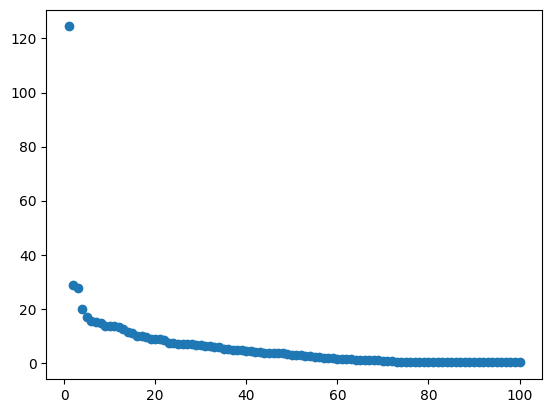

In [43]:
plt.scatter(df.ranking_2021,df.total_score)

In [47]:
# Let's remove the US, it is a pretty big outlier

df = df[~(df.country=='United States')]

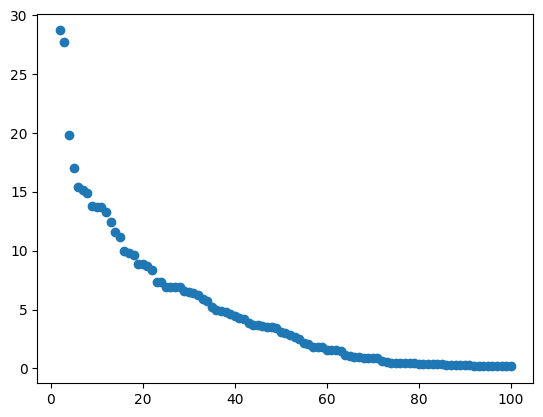

In [48]:
plt.scatter(df.ranking_2021,df.total_score)

# Again we could build a model to predict 
the ranking given the score, but if we had the scores.... we would actually know the rankings.

## Instead we are going to try to predict the stability of a countries spot in the rankings.
We we have enough information to predict. Specifically this can be seen be the plot below. The further on goes down in the rankings the more movement there is between spots. The higher up on the ranking scale there seems to be less movement.

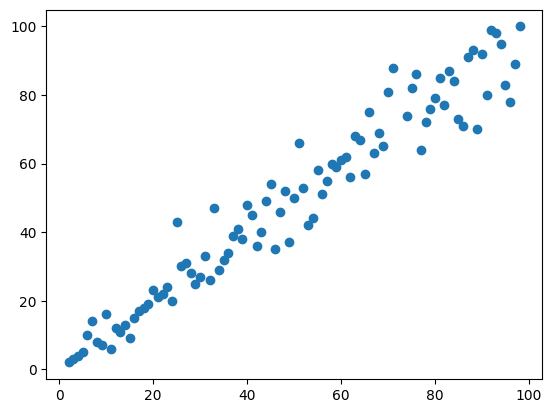

In [66]:
plt.scatter(df.ranking_2021,df.ranking_2020)

# There are a few nans that need to be imputed
Because they came from off the list to now on the list. This can be a big jump and should be included! Sincewe don't know what their ranking was in 2020, but we canbe assured it was less than 101, we will take their 2021 rankings subtracted from 100 and average all of them

In [72]:
# These 
imputed_change = (101 - df[df.change_vector.isnull()].ranking_2021.mean())
print(imputed_change)
df.change_vector.fillna(imputed_change,inplace=True)

15.0


/var/folders/5g/bxwbqkr56nq3_gvqbm97215r0000gn/T/ipykernel_28577/23728535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.change_vector.fillna(imputed_change,inplace=True)


0.2727272727272727

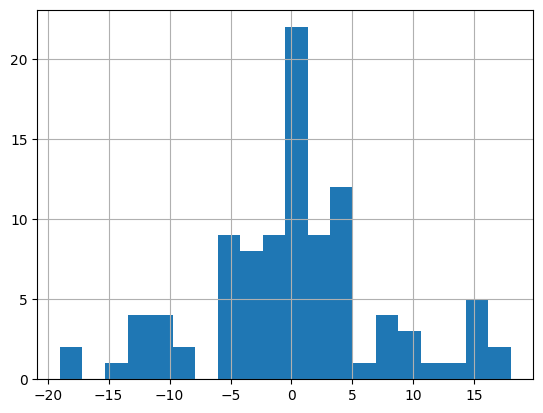

In [73]:
# Checking for normality assumption. 
df.change_vector.hist(bins=20)
df.change_vector.mean()
# plt.yscale('log')

# Not horrible, seen worse. Skewness (Countries_For_Startup.html) is also low, so OLS is probably OK.

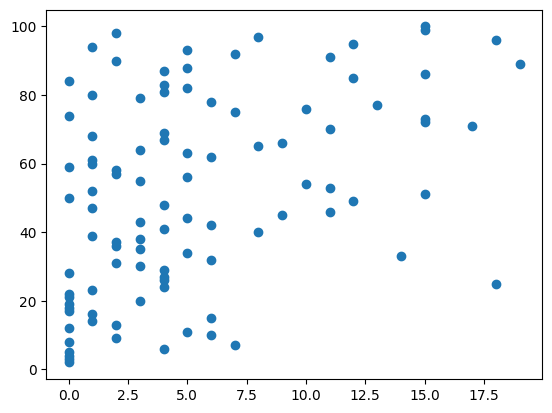

In [162]:
# I will exploit the fact that
# Var = E[x^2] - E[x]^2,
# E[x]=0,
# standard_dev = sqrt(Var),
# and abs = sqrt(x^2)
# in order to just model the absolute value of the deviation. The proof is left to the reader, lol.
plt.scatter(df.change_vector.apply(abs), df.ranking_2021)

# As we can see the variability in the ranking change 
is proportional to the ranking itself. The errors grow larger and the ranking increases (goes toward 100).

In [155]:
reg = LinearRegression().fit(df[['ranking_2021']], df.change_vector.apply(abs))
# poly = np.poly1d(np.polyfit(df.ranking_2021.values, df.change_vector.apply(abs), 7))

In [156]:
x = np.linspace(1,100,100)

In [158]:
preds = reg.predict(x.reshape(-1,1))
# preds = poly(x.reshape(-1,1)).flatten()

/Users/frizzell/archestro/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [159]:
preds

array([1.5332921 , 1.60949495, 1.68569779, 1.76190064, 1.83810348,
       1.91430633, 1.99050917, 2.06671202, 2.14291486, 2.21911771,
       2.29532055, 2.3715234 , 2.44772624, 2.52392909, 2.60013193,
       2.67633478, 2.75253762, 2.82874047, 2.90494331, 2.98114616,
       3.057349  , 3.13355184, 3.20975469, 3.28595753, 3.36216038,
       3.43836322, 3.51456607, 3.59076891, 3.66697176, 3.7431746 ,
       3.81937745, 3.89558029, 3.97178314, 4.04798598, 4.12418883,
       4.20039167, 4.27659452, 4.35279736, 4.42900021, 4.50520305,
       4.5814059 , 4.65760874, 4.73381159, 4.81001443, 4.88621727,
       4.96242012, 5.03862296, 5.11482581, 5.19102865, 5.2672315 ,
       5.34343434, 5.41963719, 5.49584003, 5.57204288, 5.64824572,
       5.72444857, 5.80065141, 5.87685426, 5.9530571 , 6.02925995,
       6.10546279, 6.18166564, 6.25786848, 6.33407133, 6.41027417,
       6.48647702, 6.56267986, 6.6388827 , 6.71508555, 6.79128839,
       6.86749124, 6.94369408, 7.01989693, 7.09609977, 7.17230

# So my guess is I lost you about here.
What does all this mean? 

It means I am guessing that the best prediction we have for the 2022 is simply the 2021 ranking (green line below). 
But we can say that the true value will be somewhere within those two orange lines below with 95% confidence. 

Text(0, 0.5, '2021 Ranking')

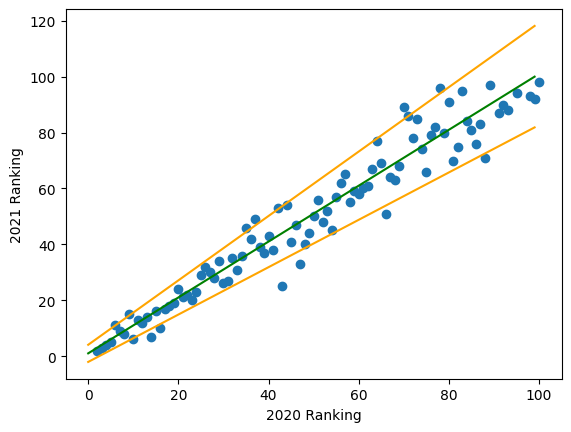

In [160]:
plt.scatter(df.ranking_2020,df.ranking_2021)
plt.plot(x,color='green')
plt.plot(x+ preds*2, color='orange')
plt.plot(x- preds*2, color='orange')
plt.xlabel("2020 Ranking")
plt.ylabel("2021 Ranking")

# Formally save the 2022 predictions


In [184]:
df['ranking_2022'] = df.ranking_2021 
df['ranking_2022_up'] = df['ranking_2022'] + preds[1:]*2 # 2 sigma confidence
df['ranking_2022_down'] = df['ranking_2022'] - preds[1:]*2 # 2 sigma confidence

final = df[['country','ranking_2021','ranking_2022','ranking_2022_up','ranking_2022_down']]

us = pd.DataFrame({
                    'country':'United States',
                   'ranking_2021': 1.0,
                   'ranking_2022': 1.0,
                   'ranking_2022_up': np.nan,
                   'ranking_2022_down': np.nan},index=[0])
final = final.append(us,ignore_index=True)

final.to_csv('final_guesses.csv')

/var/folders/5g/bxwbqkr56nq3_gvqbm97215r0000gn/T/ipykernel_28577/3807454940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ranking_2022'] = df.ranking_2021
/var/folders/5g/bxwbqkr56nq3_gvqbm97215r0000gn/T/ipykernel_28577/3807454940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ranking_2022_up'] = df['ranking_2022'] + preds[1:]*2 # 2 sigma confidence
/var/folders/5g/bxwbqkr56nq3_gvqbm97215r0000gn/T/ipykernel_28577/3807454940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

# But Dylan,
It looks like you went a really long way to get a very simple result in a textbook linear regression problem with heterscedastic errors. 

But there is something special here. I have a dynamic prediction interval as opposed to a rough estimate given by the standard deviation of the model residuals or a model confidence interval. This can be done by packages such as : https://mapie.readthedocs.io/en/latest/index.html. But I felt like I needed to model something by hand to demonstrate data prep, etc. 

A common error, is to report a confience interval when one intends to report a prediction interval. This is mathematically similar to reporting the "standard deviation of the estimate of the mean" when one really intends to report the model's predictive capability. Note the 95% CI generated by seaborn below, and compare the size of the prediction interval versus the confidence interval.

Also in the code above you can see where I tried out some non-linear prediction interval estimates for fun.

<AxesSubplot: xlabel='ranking_2021', ylabel='ranking_2020'>

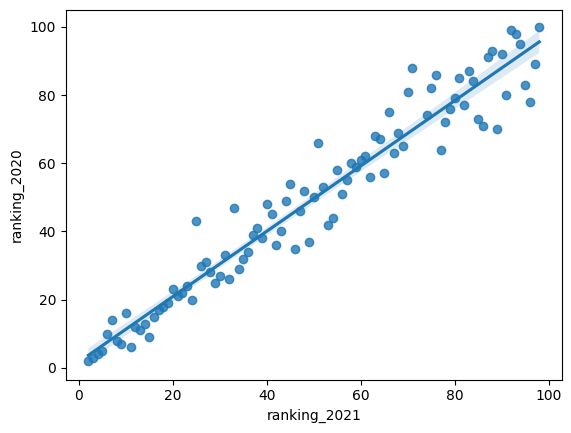

In [185]:
sns.regplot(x="ranking_2021", y="ranking_2020", data=df,ci=95)

In [126]:
import pickle

In [127]:
pickle.dump(reg, open('reg.pkl', 'wb'))